In [1]:
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import config
from dataset import OCRDataset
from model import OCRResNet34
import utils

In [2]:
selected_annotation_list, index_to_utf16 = utils.prepare_selected_annotation_from_dataset_indexes([6, 12])
train_annotation_list, validation_annotation_list = train_test_split(selected_annotation_list,
                                                                     test_size=0.2,
                                                                     random_state=config.RANDOM_SEED)

In [3]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = OCRDataset(train_annotation_list, transform=tf)
validation_dataset = OCRDataset(validation_annotation_list, transform=tf)

batchsize = 16
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = OCRResNet34(5*config.N_KINDS_OF_CHARACTERS, pretrained=True)
net = net.to(device)
params = torch.load('../../data/komonjo/logs/20190325/weight_200.pth')
net.load_state_dict(params)

In [5]:
import numpy as np
def NMS(bboxes, border=0.3):
    bbox_indexes = np.argsort(bboxes[0])[::-1]
    NMS_result_indexes = list()
    print(bboxes)
    while len(bbox_indexes) != 0:
        NMS_result_indexes.append(bbox_indexes[0])
        IOUs = utils.compute_IOU(bboxes[:, bbox_indexes[0]][1:],
                                 bboxes[:, bbox_indexes][1:])
        bbox_indexes = bbox_indexes[IOUs < border]
    return NMS_result_indexes

In [29]:
def show_result(image, bboxes, use_NMS=False, border=0.5):
    fontpath = '../../font/HanaMinA.ttf'
    font = ImageFont.truetype(fontpath, 14)
    
    toPIL = transforms.ToPILImage()
    image_PIL = toPIL(image*0.5 + 0.5)
    draw = ImageDraw.Draw(image_PIL)
    for char_index, bboxes_per_class in enumerate(bboxes):
        confidence, center_x, center_y, width, height = bboxes_per_class
        min_x = center_x - 0.5*width
        min_y = center_y - 0.5*height
        max_x = center_x + 0.5*width
        max_y = center_y + 0.5*height
        if use_NMS:
            bboxes_per_class_for_NMS = np.array([confidence, min_x, min_y, max_x, max_y])
            remaining_indexes = utils.NMS(bboxes_per_class_for_NMS, border=border)
            bboxes_per_class_after_NMS = bboxes_per_class_for_NMS[:, remaining_indexes]
            confidence, min_x, min_y, max_x, max_y = bboxes_per_class_after_NMS
        utf16 = index_to_utf16[char_index]
        mess = (('\\u' + utf16[2:]).encode()).decode('unicode-escape')
        for minx, miny, maxx, maxy in zip(min_x, min_y, max_x, max_y):
            draw.rectangle((minx, miny, maxx, maxy), fill=None, outline=(0,255,0))
            draw.text((maxx, miny), mess, font=font, fill=(0,0,255))
    return image_PIL

In [30]:
train_images, train_labels = iter(train_loader).next()
validation_images, validation_labels = iter(validation_loader).next()

net.eval()
with torch.no_grad():
    train_preds = net(train_images.to(device))
    validation_preds = net(validation_images.to(device))

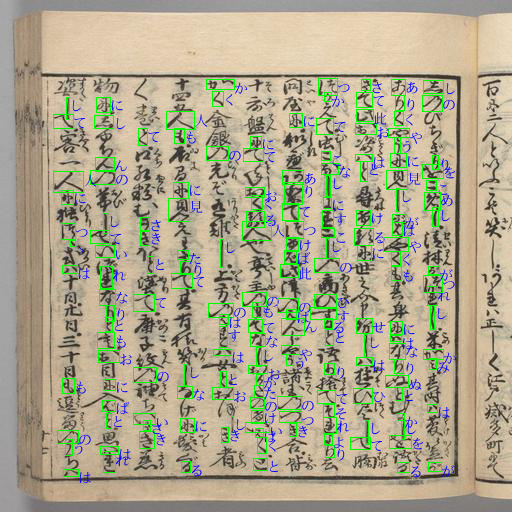

In [31]:
index = 0
image = train_images[index]
bboxes = train_dataset.label2bboxes(train_labels[index])
show_result(image, bboxes)

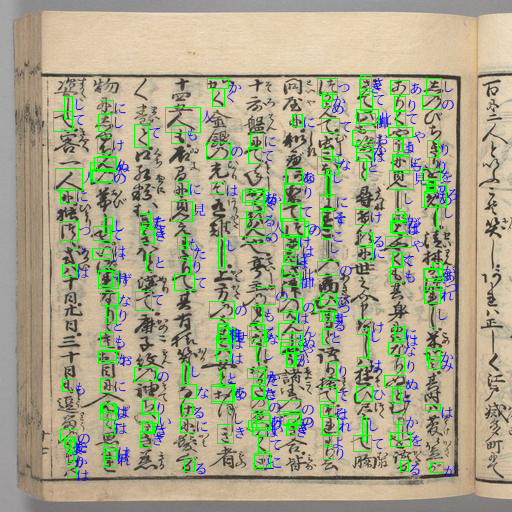

In [32]:
image = train_images[index]
bboxes = train_dataset.label2bboxes(train_preds[index].cpu(), confidence_border=0.95)
show_result(image, bboxes, use_NMS=True, border=0.1)

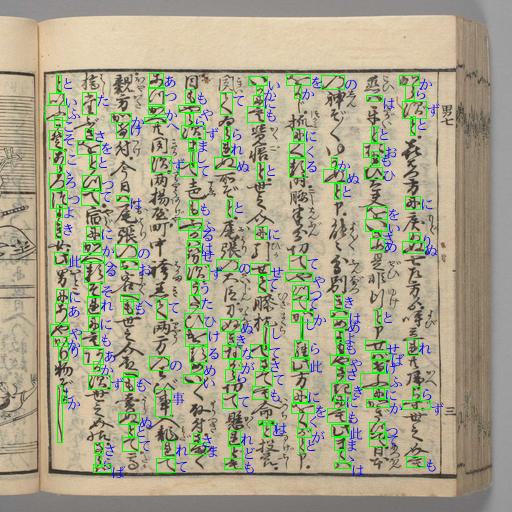

In [33]:
index = 0
image = validation_images[index]
bboxes = validation_dataset.label2bboxes(validation_labels[index])
show_result(image, bboxes)

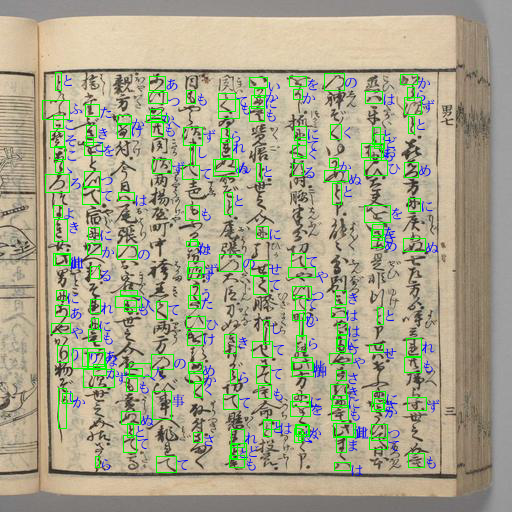

In [34]:
image = validation_images[index]
bboxes = validation_dataset.label2bboxes(validation_preds[index].cpu(), confidence_border=0.99)
show_result(image, bboxes, use_NMS=True, border=0.1)